<a href="https://colab.research.google.com/github/tanjimanasreen/GoogleMaps-Restaurant-Scraper/blob/main/Restaurant_Scrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries
---

In [12]:
%%capture

!pip install python-google-places

In [13]:
from googleplaces import GooglePlaces, types, lang
import time
import pandas as pd

# Location Dataset 
---
This dataset contains the list of Upazilla/Thana for Different Districts of Bangladesh.

Credit : [Mobile network coverage in Bangladeshi Upazila or Thana - kaggle](https://www.kaggle.com/mushfiqurrobin/network-coverage)

In [14]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mushfiqurrobin/network-coverage

!mkdir network-coverage
!unzip network-coverage.zip -d network-coverage

  0% 0.00/369k [00:00<?, ?B/s]
100% 369k/369k [00:00<00:00, 42.9MB/s]
Archive:  network-coverage.zip
  inflating: network-coverage/Coverage.csv  


In [15]:
df = pd.read_csv("/content/network-coverage/Coverage.csv")

df_area = df[['Upazila_or_Thana', 'District']]

# Checking For Missing Values
total = df_area.isnull().sum().sort_values(ascending=False)
percent = (df_area.isnull().sum()/df_area.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=['Total', 'Percent'])
display(missing_data.head(5))

,Total,Percent
District,0,0.0
Upazila_or_Thana,0,0.0


In [16]:
# Checking for Duplicate Rows 
df_area.duplicated().sum()

21800

In [ ]:
# Dropping Duplicates
df_area.drop_duplicates(keep="first", inplace=True)
df_area.reset_index(drop=True, inplace=True)

df_area.to_csv("locations.csv", index=False)

# Initialization
---
Here, I am combining the Upazilla/Thana and its dedicated District into a string and storing them into ``` locations``` list. Later I will use this list for the searching query.

I have also intialized the searching ``` radius ``` to 2000 Meter or 2 KM. 

Finally, I will store the Restaurants' information into ```restaurant_data``` 



In [18]:
API_KEY = "YOUR API KEY"

google_places = GooglePlaces(API_KEY)

restaurant_data = []
radius = 2000

# Converting the list of Upazilla/Thana and District into a combined string
locations = []
list_areas = df_area.values.tolist()

for area in list_areas:
  location_name = ', '.join([str(item) for item in area])
  locations.append(location_name)

print(locations)

['Kawkhali, Pirojpur', 'Mathbaria, Pirojpur', 'Nazirpur, Pirojpur', 'Nesarabad, Pirojpur', 'Pirojpur Sadar, Pirojpur', 'Zianagar, Pirojpur', 'Akhaura, Brahmanbaria', 'Ashuganj, Brahmanbaria', 'Brahmanbaria Sadar, Brahmanbaria', 'Bancharampur, Brahmanbaria', 'Bijoynagar, Brahmanbaria', 'Kasba, Brahmanbaria', 'Nabinagar, Brahmanbaria', 'Nasirnagar, Brahmanbaria', 'Sarail, Brahmanbaria', 'Alikadam, Bandarban', 'Bandarban Sadar, Bandarban', 'Lama, Bandarban', 'Naikhongchhari, Bandarban', 'Rowangchari, Bandarban', 'Ruma, Bandarban', 'Thanchi, Bandarban', 'Chandpur Sadar, Chandpur', 'Faridganj, Chandpur', 'Haimchar, Chandpur', 'Hajiganj, Chandpur', 'Kachua, Chandpur', 'Matlab (Dakshin), Chandpur', 'Matlab (Uttar), Chandpur', 'Shahrasti, Chandpur', 'Anwara, Chittagong', 'Banskhali, Chittagong', 'Boalkhali, Chittagong', 'Chandanish, Chittagong', 'Fatikchari, Chittagong', 'Karnaphuli, Chittagong', 'Lohagara, Chittagong', 'Mirsharai, Chittagong', 'Patiya, Chittagong', 'Rangunia, Chittagong', 'Ra

# Restaurant Scraper 

---



In [ ]:
%%time

for location in locations:
  print("---------------------", location, "-----------------------")
  query_result = google_places.nearby_search(
          location=location, keyword='Restaurant',
          radius=radius) 

  if query_result:
  
    for place in query_result.places:
      place.get_details()

      place_id = place.details.get('place_id')
      name = place.name
      latitude = place.geo_location.get('lat')
      longitude = place.geo_location.get('lng')
      rating = place.rating
      number_of_reviews = place.details.get('user_ratings_total')
      affluence = place.details.get('price_level')
      address = place.formatted_address

      restaurant_data.append([place_id, name, latitude, longitude, rating, number_of_reviews, affluence, address])
      # print(place.details)

    # print(restaurant_data)
    print("--------------------- Scrapped Restaurants: ", len(restaurant_data))
    time.sleep(5) 

    while query_result.has_next_page_token:
        query_result = google_places.nearby_search(location=location, keyword='Restaurant',
            radius=radius, pagetoken=query_result.next_page_token)
        
        for place in query_result.places:
          place.get_details()

          place_id = place.details.get('place_id')
          name = place.name
          latitude = place.geo_location.get('lat')
          longitude = place.geo_location.get('lng')
          rating = place.rating
          number_of_reviews = place.details.get('user_ratings_total')
          affluence = place.details.get('price_level')
          address = place.formatted_address

          restaurant_data.append([place_id, name, latitude, longitude, rating, number_of_reviews, affluence, address])
          # print(place.details)
        # print(restaurant_data)  
        print("--------------------- Scrapped Restaurants: ", len(restaurant_data))
        time.sleep(5) 

  time.sleep(5)

# Dumping the data into a DataFrame
df_restaurant = pd.DataFrame(restaurant_data, columns=['place_id', 'name', 'latitude', 'longitude', 'rating', 'number_of_reviews', 'affluence', 'address'])

df_restaurant.to_csv("restaurants.csv", index=False, encoding='utf-8')

# Data Preparation

---


In [66]:
restaurant_df = pd.read_csv("/content/restaurants.csv", encoding='utf-8')

display(restaurant_df.duplicated().sum())

1945

**There are 1945 Duplicate Data present in the dataframe.**

In [67]:
restaurant_df.drop_duplicates(keep="first", inplace=True)

**Here, I kept the address of each restaurant to check whether they are in Bangladeh or Not. As we can see below, 62 restaurants are in India.**

In [68]:
res_not_bangladesh = restaurant_df[restaurant_df['address'].str.contains('Bangladesh')==False]
res_not_bangladesh

,place_id,name,latitude,longitude,rating,number_of_reviews,affluence,address
2249,ChIJM3pmh-oZUzcRxEj0i0X72NM,Juice🍹& Spice🌶,23.003974,91.729881,0.0,NaN,NaN,"2P3H+HXJ, Sabroom, Tripura 799145, India"
2252,ChIJ2dxRyT0ZUzcRVlumPmgbV3c,Pushpa fast food,23.000829,91.727325,4.7,9.0,NaN,"Pushpa fast food chotokhil Rd, opposite of bag..."
2258,ChIJi_nlqHcZUzcRKjNPd5Cctnk,Upalabdhi Food Plaza,23.002733,91.729778,3.5,4.0,NaN,"2P3H+3WR, Sabroom, Tripura 799145, India"
2264,ChIJAWkn0lsZUzcRI1rLiUVf23o,Sabroom New Bus Stand,23.009141,91.725767,4.5,2.0,NaN,"2P5G+M82, Sabroom, Tripura 799145, India"
6347,ChIJczRZgTMB-zkRgvpD1QO1Yt8,M/S. Prapty Caterer & NANDITA Biriyani House,24.959450,88.240887,2.0,3.0,NaN,"Aiho, West Bengal 732121, India"
...,...,...,...,...,...,...,...,...
8967,ChIJZxA1UjjTUTcRh4Rn0s1dzog,Corner Cafe,24.871413,92.359391,3.3,132.0,NaN,"V9C5+HQ6, Karimganj, Assam 788710, India"
8968,ChIJS34qNcrTUTcRnUTJMI3uwL0,Hotel City View,24.869049,92.364834,3.8,5.0,NaN,"Main Road, opp. Congress Office, Karimganj, As..."
8969,ChIJw27U4zvTUTcRx5sfB5fjcPU,Mamoni Hotel,24.869008,92.356553,3.2,34.0,NaN,"Circuit House Rd, Karimganj, Assam 788710, India"
8970,ChIJ7WS_-EPTUTcRmnPXC2fm4W4,Ahar Hotel And Aheli Restaurant,24.867414,92.366639,3.6,250.0,NaN,"Shiv Bari Rd, Near Shib Mandir, Karimganj, Ass..."


In [69]:
restaurant_df = restaurant_df[restaurant_df['address'].str.contains('Bangladesh')==True]
restaurant_df.reset_index(drop=True, inplace=True)

**Now the dataframe ```restaurant_df``` contains only Bangladeshi restaurants.**

Number of rows with at least 1 missing values: 9675
Number of columns with missing values: 3

Missing percentage (desceding):


,Total,Percent
affluence,9672,90.426328
number_of_reviews,2528,23.635004
rating,1,0.009349


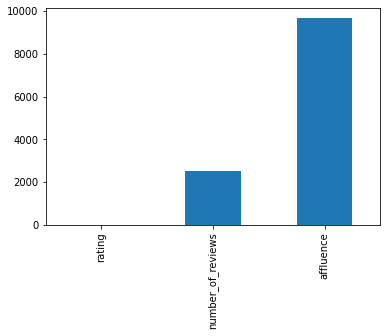

In [70]:
def missing_value_describe(data):
    # check missing values in the data
    total = data.isna().sum().sort_values(ascending=False)
    missing_value_pct_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_pct_stats > 0)

    # missing_value_stats = missing_value_pct_stats.sort_values(ascending=False)[:missing_value_col_count]
    missing_data = pd.concat([total, missing_value_pct_stats], axis=1, keys=['Total', 'Percent'])

    print("Number of rows with at least 1 missing values:", data.isna().any(axis = 1).sum())
    print("Number of columns with missing values:", missing_value_col_count)

    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        display(missing_data[:missing_value_col_count])

        # plot missing values
        missing = data.isnull().sum()
        missing = missing[missing > 0]
        missing.sort_values(inplace=True)
        missing.plot.bar()
    else:
        print("No missing data!!!")

# pass a dataframe to the function
missing_value_describe(restaurant_df)

**Converting the Affluence Level ```1.0, 2.0, 3.0...``` to ```$, $$, $$$...```**

In [62]:
restaurant_df['affluence'] = restaurant_df['affluence'].replace([1.0, 2.0, 3.0, 4.0],['$', '$$', '$$$', '$$$$'])
restaurant_df[restaurant_df['affluence'].notna()==True]

,place_id,name,latitude,longitude,rating,number_of_reviews,affluence,address
12,ChIJJwuMBKoLADoRcGUOid7tMUg,ক্যাফে আড্ডা মঠবাড়িয়া,22.286668,89.958363,3.9,165.0,$$,"7XP5+M89, Mathbaria, Bangladesh"
30,ChIJR6ppFA5RVTcR7vhuJ_FPWME,Touhid Tea Store,22.746173,90.103694,4.1,37.0,$,"Swarupkathi Bridge, Swarupkathi, Bangladesh"
81,ChIJkdicn2gBADoRZgU_lUomDDw,Hotel Rose Garden,22.578679,89.968584,3.8,81.0,$,"Post Office Rd, Pirojpur Pourashava, Bangladesh"
87,ChIJEyplIFEAADoRw_6MExFtfr8,Hotel Apyayon,22.579484,89.969643,3.5,31.0,$,"HXH9+QVR, Pirojpur Pourashava, Bangladesh"
92,ChIJIRrrteQJVDcRi_9mQMEBerA,Nawab Chinese Restaurant and Party Center,23.865913,91.206187,4.4,50.0,$,"Shahid Amir Hossen Road (1st floor, আখাউড়া, B..."
...,...,...,...,...,...,...,...,...
10669,ChIJ-daAjkXu-zkRKA09tfrQTSI,Party Point Thai and Chinese Restaurant,24.386058,88.608380,3.9,196.0,$$,"Ground floor,1st and 2nd Floor, B.G.B Gate Rif..."
10681,ChIJKx-b407u-zkR7VQuYVQ6ysk,Razia Chinese and Thai Restaurant,24.383917,88.607963,3.7,49.0,$$,"R685, Rajshahi 6203, Bangladesh"
10685,ChIJbUqeQkXu-zkRPx152Vjuq3w,Muskan Hotel And Restaurant,24.388027,88.606072,3.8,99.0,$,"Bisik Match Factory Moor, Sapura, Boalia, Rajs..."
10686,ChIJJ0af2v_u-zkRhBVjVemblw0,Mona Hotel & Restaurant,24.375834,88.593381,3.7,14.0,$,"9HGV+89J, Rajshahi, Bangladesh"


**Saving the final dataframe into CSV**

In [65]:
final_df = restaurant_df[['name',	'latitude',	'longitude',	'rating',	'number_of_reviews',	'affluence']]

final_df.to_csv("bangladesh_restaurants.csv", index=False, encoding='utf-8')

# Remarks


---

**The dataset may contain some anomalies such as Tea Stores or Food Stores that are also registered under Restaurant keyword. More extensive cleaning can be done to handle such issues in the future.**
